<a href="https://colab.research.google.com/github/AlexandreLarget/advanced_computer_vision/blob/main/06_ACP_ResNet_bloodCell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the data

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = [224, 224]

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/blood_cell_images.zip

--2022-12-12 04:30:24--  https://lazyprogrammer.me/course_files/blood_cell_images.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109834540 (105M) [application/zip]
Saving to: ‘blood_cell_images.zip’

blood_cell_images.z 100%[===================>] 104.75M  1.23MB/s    in 93s     

2022-12-12 04:31:58 (1.13 MB/s) - ‘blood_cell_images.zip’ saved [109834540/109834540]



In [ ]:
!unzip -nq blood_cell_images.zip

In [ ]:
!ls blood_cell_images

TEST  TEST_SIMPLE  TRAIN


In [ ]:
from glob import glob

In [ ]:
train_path = "blood_cell_images/TRAIN"
valid_path = "blood_cell_images/TEST"

In [ ]:
image_files = glob(train_path + "/*/*.jp*g")
valid_images = glob(valid_path + "/*/*.jp*g")

In [ ]:
folders = glob(train_path + "/*")
folders

['blood_cell_images/TRAIN/EOSINOPHIL',
 'blood_cell_images/TRAIN/NEUTROPHIL',
 'blood_cell_images/TRAIN/LYMPHOCYTE',
 'blood_cell_images/TRAIN/MONOCYTE']

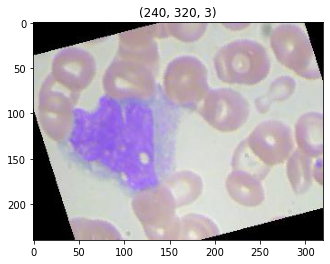

In [ ]:
sample = image.img_to_array(image.load_img(np.random.choice(image_files))).astype("uint8")
plt.imshow(sample)
plt.title(sample.shape);

# Hand-build ResNet

In [ ]:
def identity_block(input_, kernel_size, filters):
  f1, f2, f3 = filters

  x = layers.Conv2D(f1, kernel_size = (1, 1), 
                    # kernel_initializer="he_normal",
                    )(input_)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(f2, kernel_size, padding="same",
                    # kernel_initializer="he_normal",
                    )(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(f3, kernel_size=(1, 1),
                    # kernel_initializer="he_normal",
                    )(x)
  x = layers.BatchNormalization()(x)

  x = layers.add([x, input_])
  x = layers.Activation("relu")(x)

  return x

In [ ]:
i = layers.Input(shape=[100, 100, 3])
x = layers.Conv2D(2, kernel_size=(1, 1))(i)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(4, kernel_size=(3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(3, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)

x = layers.add([x, i])
x = layers.Activation("relu")(x)

In [ ]:
model = tf.keras.Model(i, x)

In [ ]:
from tensorflow.keras.utils import plot_model

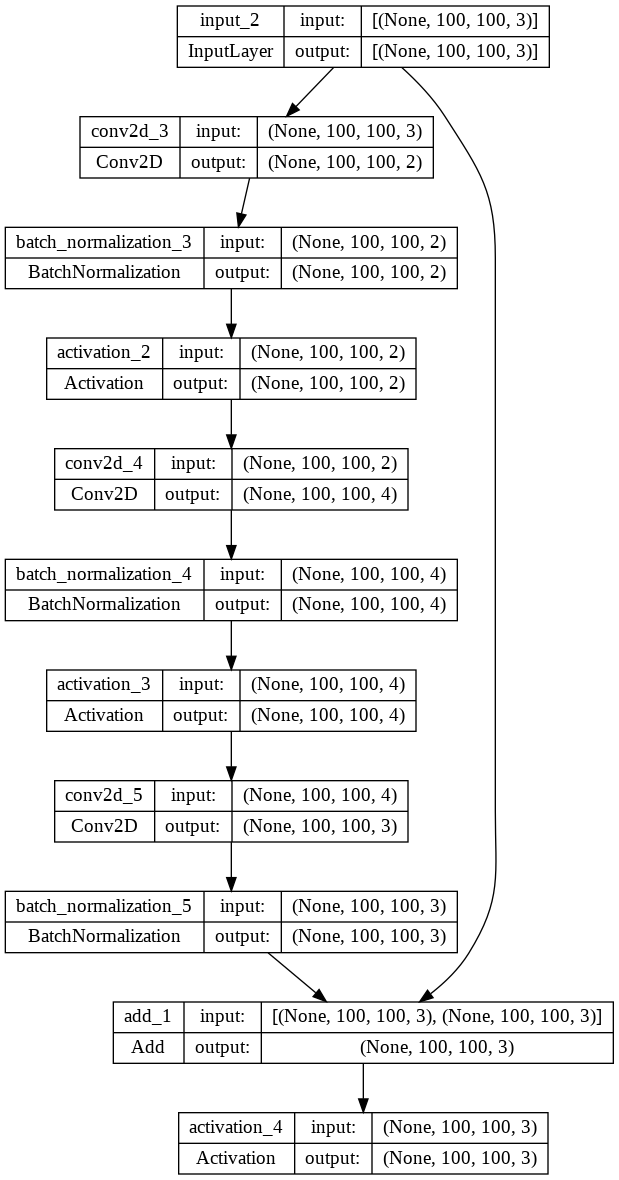

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
def conv_block(input_, kernel_size, filters, strides=(2, 2)):
  f1, f2, f3 = filters

  x = layers.Conv2D(f1, kernel_size=(1, 1), strides=strides,
                    # kernel_inititalizer="he_normal",
                    )(input_)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(f2, kernel_size, padding="same",
                    # kernel_initializer="he_normal",
                    )(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(f3, kernel_size=(1, 1),
                    # kernel_initializer="he_normal",
                    )(x)
  x = layers.BatchNormalization()(x)

  shortcut = layers.Conv2D(f3, kernel_size=(1, 1), strides=strides,
                           # kernel_initializer="he_normal",
                           )(input_)
  shortcut = layers.BatchNormalization()(shortcut)

  x = layers.add([x, shortcut])
  x = layers.Activation("relu")(x)

  return x

In [ ]:
i = layers.Input(shape=[100, 100,3])
x = layers.Conv2D(2, kernel_size=(1, 1), strides=(2,2))(i)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(4, kernel_size=(3,3), padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

x = layers.Conv2D(8, kernel_size=(1, 1))(x)
x = layers.BatchNormalization()(x)

shortcut = layers.Conv2D(8, kernel_size=(1, 1), strides=(2,2))(i)
shortcut = layers.BatchNormalization()(shortcut)

x = layers.add([x, shortcut])
x = layers.Activation("relu")(x)

In [ ]:
model = tf.keras.Model(i,x)

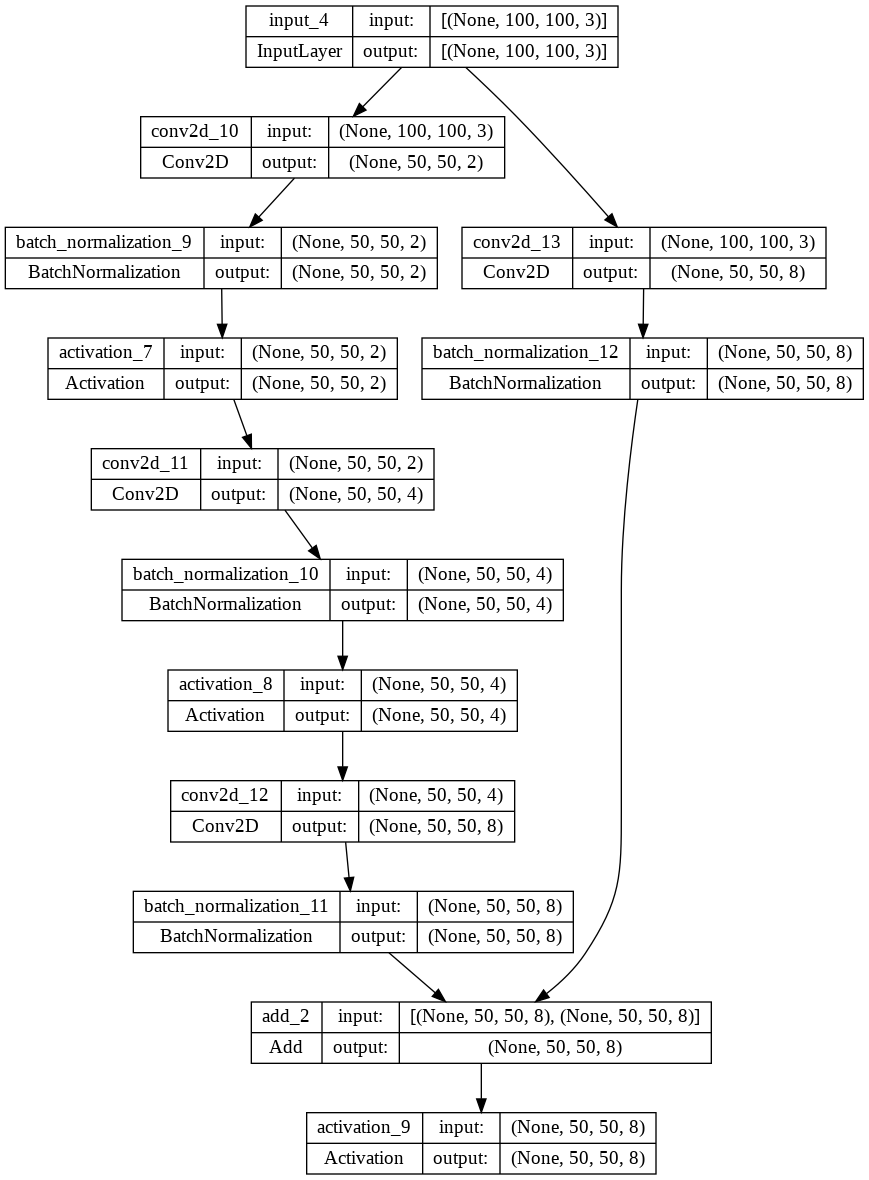

In [ ]:
plot_model(model, show_shapes=True)

In [ ]:
# our custom ResNet
i = layers.Input(shape=IMAGE_SIZE + [3])
x = layers.ZeroPadding2D(padding=(3,3))(i)
x = layers.Conv2D(64, (7,7), strides=(2,2), padding="valid")(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)
x = layers.ZeroPadding2D(padding=(1,1))(x)
x = layers.MaxPool2D(pool_size=(3,3), strides=(2,2))(x)

x = conv_block(x, kernel_size=3, filters=[64, 64, 256], strides=(1,1))
x = identity_block(x, kernel_size=3, filters=[64, 64, 256])
x = identity_block(x, kernel_size=3, filters=[64, 64, 256])

x = conv_block(x, kernel_size=3, filters=[128, 128, 512])
x = identity_block(x, kernel_size=3, filters=[128, 128, 512])
x = identity_block(x, kernel_size=3, filters=[128, 128, 512])
x = identity_block(x, kernel_size=3, filters=[128, 128, 512])

In [ ]:
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)
prediction = layers.Dense(len(folders), activation="softmax")(x)

In [ ]:
model = tf.keras.Model(i, prediction)

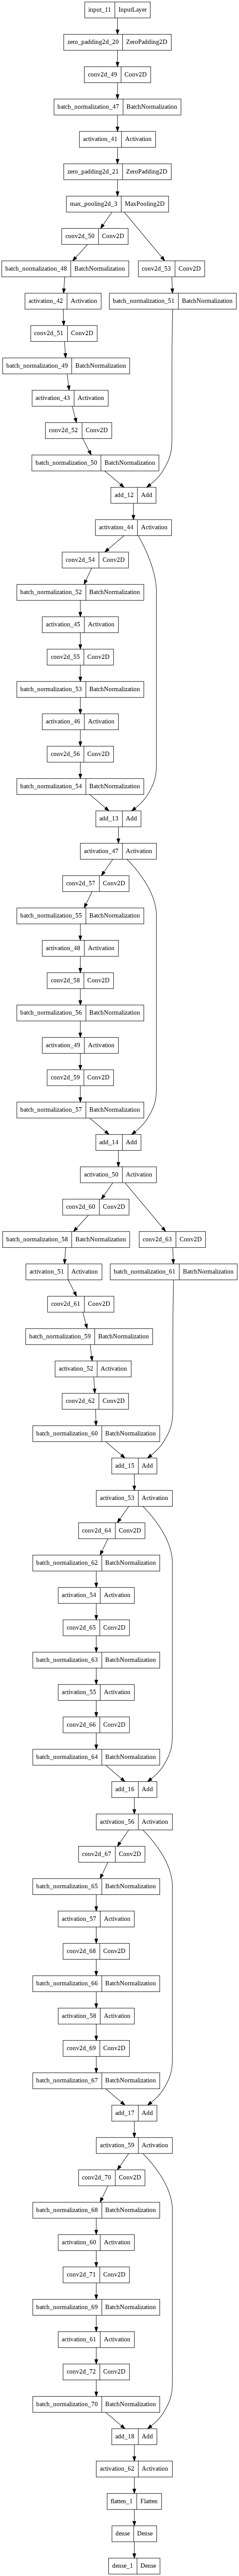

In [ ]:
plot_model(model)

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])

# Data generator

In [ ]:
# Function to rescale data between -1 and 1
def preprocess_input2(x):
  x /= 127.5
  x -= 1.
  return x

In [ ]:
train_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input2
)

In [ ]:
val_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input2
)

In [ ]:
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE,
                                       class_mode="sparse")
labels= [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
  labels[v] = k

Found 2487 images belonging to 4 classes.


min -1.0 max 0.92156863


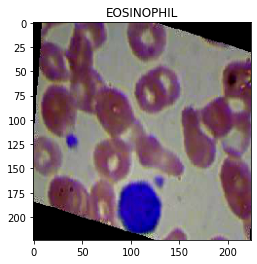

In [ ]:
for x, y in test_gen:
  print("min", x[0].min(), "max", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break

In [ ]:
train_generator = train_gen.flow_from_directory(train_path, target_size=IMAGE_SIZE,
                                                class_mode="sparse",batch_size=32,
                                                shuffle=True)

Found 9957 images belonging to 4 classes.


In [ ]:
valid_generator = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE,
                                              class_mode="sparse", batch_size=32,
                                              shuffle=True)

Found 2487 images belonging to 4 classes.


In [ ]:
checkpoint_filepath = "/tmp/checkpoint"
r = model.fit(train_generator,
              validation_data=valid_generator,
              epochs=15,
              steps_per_epoch=len(image_files) // 32,
              validation_steps=len(valid_images) // 32,
              callbacks=[tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor="val_accuracy", save_best_only=True)])

Epoch 1/15
311/311 [==============================] - ETA: 0s - loss: 6.6867 - accuracy: 0.3283

311/311 [==============================] - 160s 514ms/step - loss: 6.6867 - accuracy: 0.3283 - val_loss: 2.9601 - val_accuracy: 0.2756
Epoch 2/15
311/311 [==============================] - ETA: 0s - loss: 1.1442 - accuracy: 0.6552

311/311 [==============================] - 157s 503ms/step - loss: 1.1442 - accuracy: 0.6552 - val_loss: 2.3490 - val_accuracy: 0.5463
Epoch 3/15
311/311 [==============================] - ETA: 0s - loss: 0.4840 - accuracy: 0.8513

311/311 [==============================] - 158s 508ms/step - loss: 0.4840 - accuracy: 0.8513 - val_loss: 0.8582 - val_accuracy: 0.7703
Epoch 4/15
311/311 [==============================] - ETA: 0s - loss: 0.2988 - accuracy: 0.8992

311/311 [==============================] - 159s 510ms/step - loss: 0.2988 - accuracy: 0.8992 - val_loss: 1.2385 - val_accuracy: 0.7975
Epoch 5/15
311/311 [==============================] - 143s 458ms/step - loss: 0.2424 - accuracy: 0.9194 - val_loss: 2.0363 - val_accuracy: 0.6883
Epoch 6/15
311/311 [==============================] - 139s 448ms/step - loss: 0.1526 - accuracy: 0.9463 - val_loss: 1.5363 - val_accuracy: 0.7431
Epoch 7/15
311/311 [==============================] - ETA: 0s - loss: 0.1585 - accuracy: 0.9477

311/311 [==============================] - 158s 508ms/step - loss: 0.1585 - accuracy: 0.9477 - val_loss: 0.7729 - val_accuracy: 0.7987
Epoch 8/15
311/311 [==============================] - 140s 448ms/step - loss: 0.2511 - accuracy: 0.9244 - val_loss: 3.4977 - val_accuracy: 0.6814
Epoch 9/15
311/311 [==============================] - ETA: 0s - loss: 0.1713 - accuracy: 0.9446

311/311 [==============================] - 157s 506ms/step - loss: 0.1713 - accuracy: 0.9446 - val_loss: 0.7991 - val_accuracy: 0.8588
Epoch 10/15
311/311 [==============================] - 139s 446ms/step - loss: 0.0974 - accuracy: 0.9658 - val_loss: 2.0183 - val_accuracy: 0.8032
Epoch 11/15
311/311 [==============================] - 138s 442ms/step - loss: 0.0986 - accuracy: 0.9669 - val_loss: 1.7036 - val_accuracy: 0.8028
Epoch 12/15
311/311 [==============================] - 138s 444ms/step - loss: 0.1138 - accuracy: 0.9643 - val_loss: 1.1430 - val_accuracy: 0.8515
Epoch 13/15
311/311 [==============================] - 138s 443ms/step - loss: 0.0867 - accuracy: 0.9701 - val_loss: 1.5369 - val_accuracy: 0.7821
Epoch 14/15
311/311 [==============================] - 138s 443ms/step - loss: 0.1101 - accuracy: 0.9624 - val_loss: 1.5005 - val_accuracy: 0.7476
Epoch 15/15
311/311 [==============================] - 142s 456ms/step - loss: 0.1325 - accuracy: 0.9586 - val_loss: 0.7820 - val_